# Composite Adversarial Attacks in PyTorch
This notebook provides a demonstration showing how to use ART to launch the composite adversarial attack (CAA) [1]. CAA consists of the following perturbations:

- Hue
- Saturation
- Rotation
- Brightness
- Contrast
- PGD ($\ell_\infty$)

[1] Towards Compositional Adversarial Robustness: Generalizing Adversarial Training to Composite Semantic Perturbations (CVPR 2023)

In [1]:
import numpy as np
import torch.nn as nn
import torch.optim as optim

from art.attacks.evasion import CompositeAdversarialAttackPyTorch
from art.estimators.classification import PyTorchClassifier
from art.utils import load_cifar10

import matplotlib.pyplot as plt

In [2]:
(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_cifar10()

# Swap the axes to PyTorch's NCHW format.
x_train = np.transpose(x_train, (0, 3, 1, 2)).astype(np.float32)
x_test = np.transpose(x_test, (0, 3, 1, 2)).astype(np.float32)

In [3]:
# Create a simple convolutional neural network.
model = nn.Sequential(
    nn.Conv2d(3, 8, 5), nn.BatchNorm2d(8), nn.ReLU(), nn.MaxPool2d(2, 2), 
    nn.Conv2d(8, 16, 5), nn.BatchNorm2d(16), nn.ReLU(), nn.MaxPool2d(2, 2),
    nn.Flatten(), 
    nn.Linear(5*5*16, 128),    
    nn.Linear(128, 10)
)

# Define the loss function and the optimizer.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Create the ART classifier.
classifier = PyTorchClassifier(
    model=model,
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(3, 32, 32),
    nb_classes=10,
)

In [4]:
# Train the ART classifier.
classifier.fit(x_train, y_train, batch_size=64, nb_epochs=5, verbose=True)

# Evaluate the ART classifier on benign test examples.
predictions_benign = classifier.predict(x_test)

accuracy = np.sum(np.argmax(predictions_benign, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on the benign test set: {}%".format(accuracy * 100))

Accuracy on the benign test set: 50.839999999999996%


## Launch Composite Adversarial Attack

`CompositeAdversarialAttack` has the following parameters:
- `classifier`: A trained PyTorch classifier.
- `enabled_attack`: Attack pool selection, and attack order designation for `fixed` order. For simplicity, we use the following abbreviations to specify each attack types. 0: Hue, 1: Saturation, 2: Rotation, 3: Brightness, 4: Contrast, 5: PGD ($\ell_\infty$).
- `hue_epsilon`: The boundary of the hue perturbation. The value is expected to be in the interval `[-np.pi, np.pi]`. Perturbation of `0` means no shift and `-np.pi` and `np.pi` give a complete reversal of the hue channel in the HSV colour space in the positive and negative directions, respectively. See `kornia.enhance.adjust_hue` for more details.
- `sat_epsilon`: The boundary of the saturation perturbation. The value is expected to be in the interval `[0, infinity)`. Perturbation of `0` gives a black and white image, `1` gives the original image, while `2` enhances the saturation by a factor of 2. See `kornia.geometry.transform.rotate` for more details.
- `rot_epsilon`: The boundary of the rotation perturbation (in degrees). Positive values mean counter-clockwise rotation. See `kornia.geometry.transform.rotate` for more details.
- `bri_epsilon`: The boundary of the brightness perturbation. The value is expected to be in the interval `[-1, 1]`. Perturbation of `0` means no shift, `-1` gives a complete black image, and `1` gives a complete white image. See `kornia.enhance.adjust_brightness` for more details.
- `con_epsilon`: The boundary of the contrast perturbation. The value is expected to be in the interval `[0, infinity)`. Perturbation of `0` gives a complete black image, `1` does not modify the image, and any other value modifies the brightness by this factor. See `kornia.enhance.adjust_contrast` for more details.
- `pgd_epsilon`: The maximum perturbation that the attacker can introduce in the L-infinity ball.
- `early_stop`: When True, the attack will stop if the perturbed example is classified incorrectly by the classifier.
- `max_iter`: The maximum number of iterations for attack order optimization.
- `max_inner_iter`: The maximum number of iterations for each attack optimization.
- `attack_order`: Specify the scheduling type for the composite adversarial attack. The value is expected to be `fixed`, `random`, or `scheduled`. `fixed` means the attack order is the same as specified in `enabled_attack`. `random` means the attack order is randomly generated at each iteration. `scheduled` means to enable the attack order optimization proposed in the paper. If only one attack is enabled, `fixed` will be used.
- `batch_size`: The batch size to use during the generation of adversarial samples.

In [5]:
# Create the ART attacker.
attack = CompositeAdversarialAttackPyTorch(classifier,
         enabled_attack = (0,1,2,3,4,5), # 0: Hue, 1: Saturation, 2: Rotation, 3: Brightness, 4: Contrast, 5: PGD (L-infinity)
         hue_epsilon = [-np.pi, np.pi],
         sat_epsilon = [0.7, 1.3],
         rot_epsilon = [-10, 10],
         bri_epsilon = [-0.2, 0.2],
         con_epsilon = [0.7, 1.3],
         pgd_epsilon = [-8 / 255, 8 / 255],
         early_stop = True,
         max_iter = 5,
         max_inner_iter = 10,
         attack_order = "scheduled", # "scheduled", "random", or "fixed"
         batch_size = 1,
)

# Generate the adversarial examples.
x_test_adv = attack.generate(x_test, y_test)


# Evaluate the ART classifier on the adversarial examples.
predictions_adv = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions_adv, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on the adversarial test set: {}%".format(accuracy * 100))

Composite Adversarial Attack:   0%|          | 0/157 [00:00<?, ?it/s]

Accuracy on the adversarial test set: 0.0%


In [6]:
import matplotlib.pyplot as plt
# Utility function for visualising some results.
def visualise(x_test, x_test_adv, predictions_benign, predictions_adv, y_test,
              num_viz=3):
      # Indices where (predictions_adv != predictions_benign) and (predictions_benign == y_test)
      indices = np.where(np.logical_and(
            np.equal(np.argmax(predictions_benign, axis=1), np.argmax(y_test, axis=1)),
            np.not_equal(np.argmax(predictions_benign, axis=1), np.argmax(predictions_adv, axis=1))))

      x_adv_viz = x_test_adv[indices].transpose(0, 2, 3, 1) * 255.0
      x_adv_viz = x_adv_viz.astype(np.uint8)
      x_viz = x_test[indices].transpose(0, 2, 3, 1) * 255.0
      x_viz = x_viz.astype(np.uint8)
      y_viz = y_test[indices]
      predictions_benign_viz = predictions_benign[indices]
      predictions_adv_viz = predictions_adv[indices]

      for i in range(num_viz):
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(x_adv_viz[i])
            ax[0].set_title("Prediction after: {}".format(np.argmax(predictions_adv_viz, axis=1)[i]))
            ax[1].imshow(x_viz[i])
            ax[1].set_title("Prediction before: {}".format(np.argmax(predictions_benign_viz, axis=1)[i]))
            plt.show()

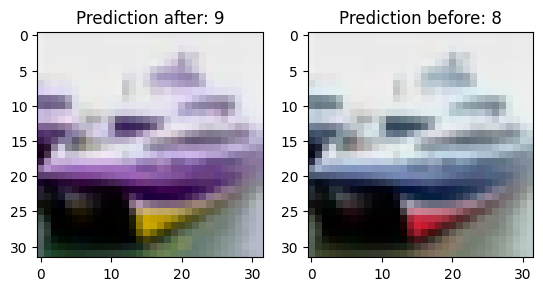

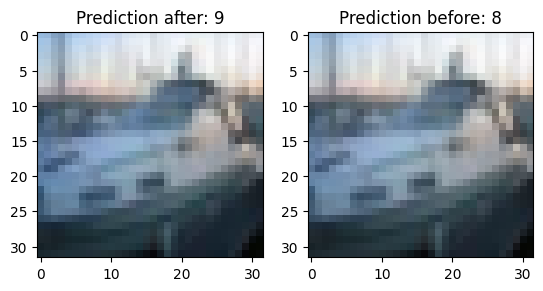

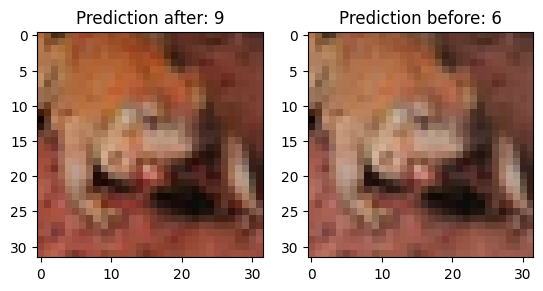

In [7]:
visualise(x_test, x_test_adv, predictions_benign, predictions_adv, y_test)